In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 40.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=6a5513937f819187eb1dfb8b3c2ddc64252058ea4a13fdd58d92a825ad2b1a6a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [45]:
from pyspark import SparkConf, SparkContext,SQLContext  
from pyspark.sql import SparkSession   
from pyspark.ml.feature import Word2Vec,CountVectorizer,IDF  
from pyspark.ml.clustering import LDA, LDAModel  
from pyspark.sql.functions import col, udf  
from pyspark.sql.types import IntegerType,ArrayType,StringType

In [46]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

path = 'gs://big_data_6893_shiyue/metavis/socrata_nycopendata_metadata_fetched_20211105.csv'
text = pd.read_csv(path)

# Remove punctuation
text['description_processed'] = text['description'].map(lambda x: re.sub('[,\.!?]', '', str(x)))

# Convert words to lowercase
text['description_processed'] = text['description_processed'].map(lambda x: x.lower()) 

# Transform words to word list
text['description_processed'] = text['description_processed'].map(lambda x: x.split())

# Remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['https', 'href', 'http', 'new', 'york', 'city', 'data', 'nyc', 'dataset']) #self add https, https, etc.

def remove_stopwords(lst):
  new_lst = []
  for word in lst:
    if word not in stop_words:
      new_lst.append(word)
  return new_lst


text['description_processed'] = text['description_processed'].map(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Transform the target column to list
lst = list(text['description_processed'])

In [48]:
from pyspark.sql import Row, SQLContext

# Spark settings
conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession \
    .builder \
    .appName("lda") \
    .getOrCreate()

In [49]:
rdd = sc.parallelize(lst)
row_rdd = rdd.map(lambda x: Row(x))
spark_df = spark.createDataFrame(row_rdd,['words'])

In [50]:
spark_df.show()

+--------------------+
|               words|
+--------------------+
|[youth, currently...|
|[gis, shapefiles,...|
|[student, discipl...|
|[directory, depar...|
|[location, dsny, ...|
|[five, year, plan...|
|[risk, assessment...|
|               [nan]|
|[agency, performa...|
|[popular, baby, n...|
|[state, calculati...|
|[(grades, 3, -, 8...|
|[k8, class, size,...|
|[please, see, fol...|
|[trends, state, a...|
|[maternal, mortal...|
|[displays, digita...|
|[opt, maintains, ...|
|[summary, environ...|
|[student, discipl...|
+--------------------+
only showing top 20 rows



In [51]:
#CountVectorizer
cv = CountVectorizer(inputCol="words", outputCol="features")
cvmodel = cv.fit(spark_df)
df_vect = cvmodel.transform(spark_df)

In [52]:
#train LDA model, cluster the documents into 12 topics 
lda = LDA(k=12, seed=1)
model = lda.fit(df_vect)

In [53]:
model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 3, 7, 4, 1...|[0.02517351768219...|
|    1|[319, 473, 38, 16...|[0.00128684586555...|
|    2|[731, 92, 104, 29...|[3.94302131312444...|
|    3|[2, 6, 16, 23, 31...|[0.00930983206860...|
|    4|[13, 41, 5, 2, 54...|[0.00626814998378...|
|    5|[20, 280, 256, 14...|[0.00553508395195...|
|    6|[196, 271, 548, 3...|[0.00351467513825...|
|    7|[22, 43, 4, 57, 2...|[0.01154237180693...|
|    8|[14, 19, 52, 11, ...|[0.00960979326107...|
|    9|[114, 54, 1252, 2...|[9.87426655582288...|
|   10|[119, 29, 127, 3,...|[0.00678795120284...|
|   11|[31, 103, 131, 98...|[0.00591180671835...|
+-----+--------------------+--------------------+



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [54]:
transformed = model.transform(df_vect)
transformed.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [55]:
lda_df = transformed.toPandas()

In [56]:
lda_df

,words,features,topicDistribution
0,"[youth, currently, residing, dycd, crisis, ser...","(0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1520457546225106, 0.001970492556687177, 0.0..."
1,"[gis, shapefiles, showing, areas, community-ba...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22198352216296774, 0.004446291724119457, 0...."
2,"[student, discipline, annual, report, english,...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006195354049451389, 0.004744338390090878, 0..."
3,"[directory, department, education, high, schoo...","(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[0.8806631360978459, 0.010230746454658848, 0.0..."
4,"[location, dsny, special, waste, drop-off, sit...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06141783894055852, 0.0017297034957568704, 0..."
...,...,...,...
3400,"[facilities, agency, site, offer, after-school...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.002503430310742394, 0.001917113795189796, 0..."
3401,"[results, state, mathematics, tests, grades, 3...","(0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0011563524953720585, 0.0008856066403477648,..."
3402,"[results, state, english, language, arts, (ela...","(2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, ...","[0.0010055921911932292, 0.0007699897658129998,..."
3403,"[school, level, college, board, sat, results, ...","(5.0, 6.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, ...","[0.9906097712127202, 0.0008050224034125209, 0...."


In [57]:
import numpy as np

lda_df['topic'] = lda_df['topicDistribution'].apply(lambda x: np.argmax(x))
lda_df

,words,features,topicDistribution,topic
0,"[youth, currently, residing, dycd, crisis, ser...","(0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1520457546225106, 0.001970492556687177, 0.0...",3
1,"[gis, shapefiles, showing, areas, community-ba...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22198352216296774, 0.004446291724119457, 0....",7
2,"[student, discipline, annual, report, english,...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006195354049451389, 0.004744338390090878, 0...",10
3,"[directory, department, education, high, schoo...","(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[0.8806631360978459, 0.010230746454658848, 0.0...",0
4,"[location, dsny, special, waste, drop-off, sit...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06141783894055852, 0.0017297034957568704, 0...",3
...,...,...,...,...
3400,"[facilities, agency, site, offer, after-school...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.002503430310742394, 0.001917113795189796, 0...",5
3401,"[results, state, mathematics, tests, grades, 3...","(0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[0.0011563524953720585, 0.0008856066403477648,...",8
3402,"[results, state, english, language, arts, (ela...","(2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, ...","[0.0010055921911932292, 0.0007699897658129998,...",8
3403,"[school, level, college, board, sat, results, ...","(5.0, 6.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, ...","[0.9906097712127202, 0.0008050224034125209, 0....",0


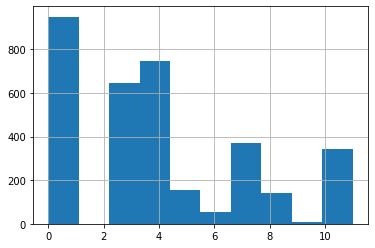

In [58]:
lda_df['topic'].hist()

In [59]:
text['topic'] = lda_df['topic']

In [61]:
lda_df = text[['data_uuid',	'category',	'name',	'description',	'description_processed',	'topic']]

In [62]:
lda_df.head()

,data_uuid,category,name,description,description_processed,topic
0,2232-dj5q,Social Services,Local Law 37 - DYCD Report,Data on the youth who are currently residing i...,"[youth, currently, residing, dycd, crisis, ser...",3
1,22gm-5ceg,Environment,Shapefiles of BOA and Community Brownfield Pla...,GIS shapefiles showing the areas in NYC where ...,"[gis, shapefiles, showing, areas, community-ba...",7
2,22rr-ujq3,Education,2016-2017 Student Discipline Annual Report - ELL,Student discipline annual report for English l...,"[student, discipline, annual, report, english,...",10
3,23z9-6uk9,Education,2020 DOE High School Directory,Directory of Department of Education High Scho...,"[directory, department, education, high, schoo...",0
4,242c-ru4i,Environment,DSNY Special Waste Drop-off Sites,Location of DSNY Special Waste Drop-Off Sites....,"[location, dsny, special, waste, drop-off, sit...",3


In [63]:
lda_df.to_csv('topic_result.csv', index=False)